# Tutorial 4.1 b: FD or FEM for a rod
In this tutorial we will compare the results of [tutorial 3.1](w3_t1.ipynb) and [tutorial 4.1](w4_t1.ipynb). they calculate the solution of a rod subject to axial loading using a Dinite Difference scheme or the Finite Element method respectively.

Let's consider the EOM of a rod of length $L$:

$$ \rho A\ddot{u}-EAu{''}=q(x,t)\qquad \forall x\in[0,L] $$

with $\rho$ the density, $A$ the cross section area, $E$ the young modulus and $q$ an external (distributed) load.

The system is subject to boundary conditions:
- $u=0$ at $x=0$
- $EAu{'}=F(t)$ at $x=L$
- The rod is at rest initially, $u(x,0) = 0$ and $\dot{u}(x,0) = 0$


In [135]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import time

In [136]:
# Parameters
L = 10
u0 = 0
u0_dt2 = 0
def P(t):
    return 10e3*np.sin(5*t)
rho = 8.0e3
A = 1e-3
E = 2.1e9
tf = 4
tspan = np.linspace(0,tf,1000)

## Part 1: FD scheme

The steps needed to discretize the rod are listed next.

1. Discretize space into $N+1$ points.
2. Discretize the EOM of the rod. To do this, you will have to approximate the 2nd order derivative with FD. Use a second order approximation. You can find the coefficients here (or google `finite difference coefficients' and click the Wikipedia page)}.
3. Apply the boundary conditions. Use the definition of discrete derivatives and EOM to find the relation between the ghost points and the interior points.
4. Combine all equations into matrices.
5. Solve the resulting ODE system

In [137]:
FD_StartTime = time.time()

# Step 1
N = 10
x = np.linspace(0,L,N+1)

In [138]:

# Step 3-4
## Construct the matrices
M = np.eye(N)
K = np.zeros((N,N))

## Fill in stiffness matrix
K[0,0] = -2;  K[0,1] = 1
K[N-1,N-2] = 2; K[N-1,N-1]=-2;
for i in range(1,N-1):
    K[i,range(i-1,i+2)] = [1, -2, 1]

## Apply scaling
dx = L/N
M = rho*A*M
K = E*A/(dx**2)*K

## Fill in force
def Fvec(t):
    Ft = np.zeros((N,))
    Ft[N-1] = Ft[N-1] + 2*P(t)/(dx)
    return Ft

In [139]:
# Step 5
## Define the ODE function (given q, return dq)
def q_dot(t,q):
    displ = q[0:N]
    velos = q[N:2*N]
    accel = np.linalg.inv(M).dot((Fvec(t)+K.dot(displ)+0.1*K.dot(velos))) #0.1 is damping factor, can change
    dq = np.zeros((2*N,))
    dq[0:N] = velos
    dq[N:2*N] = accel
    return dq

## Define initial state
q0 = np.zeros(2*N)

## Solve (we use Radau method because the ODE is very stiff and it works best for this case)
sol_FD = solve_ivp(fun=q_dot,t_span=[0,tf],y0=q0,t_eval=tspan,method='Radau')

FD_EndTime = time.time()

## Part 2: Finite Elements

In [140]:
FEM_StartTime = time.time()

# Step 1

ne = N
nn = ne + 1
xn = np.linspace(0, L, nn)
nodes = (xn, np.ones(nn))
elem_nodes = []
for ie in np.arange(0,ne):
    elem_nodes.append([ie, ie+1])
    dicts = {}
for i in np.arange(0,ne):
    dicts[i] = elem_nodes[i]

In [141]:
# Step 2

h = L/ne
N = []
dN = []
for ie in np.arange(0,ne):
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    N.append([lambda x: (xe[1]-x)/h, lambda x: (x-xe[0])/h])
    dN.append([lambda x: -1/h + 0.0*x, lambda x: 1/h + 0.0*x])

In [142]:
# Step 3

del x
import scipy.integrate as scp
M_k_num = []
for ie in np.arange(0,2):
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    M_k_num.append(np.zeros((2,2)))
    for i in np.arange(0,len(nodes)):
        for j in np.arange(0,len(nodes)):
            def eqn(x):
                return rho*A*N[ie][i](x)*N[ie][j](x)
            M_k_num[ie][i,j] = scp.quad(eqn, xe[0], xe[1])[0]
for ie in np.arange(2,ne):
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    M_k_num.append(np.zeros((2,2)))
    for i in np.arange(0,len(nodes)):
        for j in np.arange(0,len(nodes)):
            def eqn(x):
                return rho*A*N[ie][i](x)*N[ie][j](x)
            M_k_num[ie][i,j] = scp.quad(eqn, xe[0], xe[1])[0]

K_k_num = []
for ie in np.arange(0,2):
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    K_k_num.append(np.zeros((2,2)))
    for i in np.arange(0,len(nodes)):
        for j in np.arange(0,len(nodes)):
            def eqn(x):
                return E*A*dN[ie][i](x)*dN[ie][j](x)/L
            K_k_num[ie][i,j] = scp.quad(eqn, xe[0], xe[1])[0]
for ie in np.arange(2,ne):
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    K_k_num.append(np.zeros((2,2)))
    for i in np.arange(0,len(nodes)):
        for j in np.arange(0,len(nodes)):
            def eqn(x):
                return (E*A*dN[ie][i](x)*dN[ie][j](x) + E*A*dN[ie][i](x)*N[ie][j](x))/L
            K_k_num[ie][i,j] = scp.quad(eqn, xe[0], xe[1])[0]

In [143]:
# Step 4
M = np.zeros(nn*nn)
K = np.zeros(nn*nn)
for ie in np.arange(0,ne): # Loop over elements
    nodes = np.array(elem_nodes[ie])
    for i in np.arange(0, 2): # Loop over nodes
        for j in np.arange(0, 2):
            ij = nodes[i] + nodes[j]*nn
            M[ij] = M[ij] + M_k_num[ie][i,j]
            K[ij] = K[ij] + K_k_num[ie][i,j]
# Reshape the global matrix from a 1-dimensional array to a 2-dimensional array
M = M.reshape((nn, nn))
K = K.reshape((nn, nn))
def Q(t):
    return np.append(np.zeros((nn-1,1)), P(t))

fixed_dofs = np.array([0])
free_dofs = np.arange(0,nn)
free_dofs = np.delete(free_dofs, fixed_dofs)    # remove the fixed DOFs from the free DOFs array
# free & fixed array indices
fx = free_dofs[:, np.newaxis]
fy = free_dofs[np.newaxis, :]
bx = fixed_dofs[:, np.newaxis]
by = fixed_dofs[np.newaxis, :]
Mii = M[fx, fy]
Mib = M[fx, by]
Mbi = M[bx, fy]
Mbb = M[bx, by]
Kii = K[fx, fy]
Kib = K[fx, by]
Kbi = K[bx, fy]
Kbb = K[bx, by]
ub = np.array([u0])
ub_dt2 = np.array([u0_dt2])
RHS = -Mib*ub_dt2-Kib*ub

In [144]:
# Step 5

## Construct a matrix to reshape Q 
R = np.identity(nn)
R = R[fx, 0:nn]
## Set Dimensions and initial conditions of state vector
nfdofs = len(free_dofs)
udofs = np.arange(0, nfdofs)
vdofs = np.arange(nfdofs, 2*nfdofs)
q0 = np.zeros((2*nfdofs))
## Solve
def odefun(t, q):
    return np.append(q[vdofs],
                     np.linalg.solve(Mii, (np.dot(R, Q(t)) + RHS - np.dot(Kii, q[udofs]).reshape(-1, 1)))).tolist()
sol_FEM = scp.solve_ivp(fun=odefun, t_span=[tspan[0], tspan[-1]], y0=q0, t_eval=tspan)

FEM_EndTime = time.time()

## Part 3: Performance comparison

Here we will compare the two methods to each other and to a simolified analytical solution. The following conclusions can be drawn:
- Even for a small number of elements (N = 10) the FD results are very closely related to the analystical solution.
- The FEM results are a lot more accurate. However, they do take a lot longer to produce. The trade-off here is the ability to easier expand the FEM model to more complex shapes and boundary conditions.
- The FEM results show some additional high-frequency peaks. This is a consequence of the relatively low number of elements.

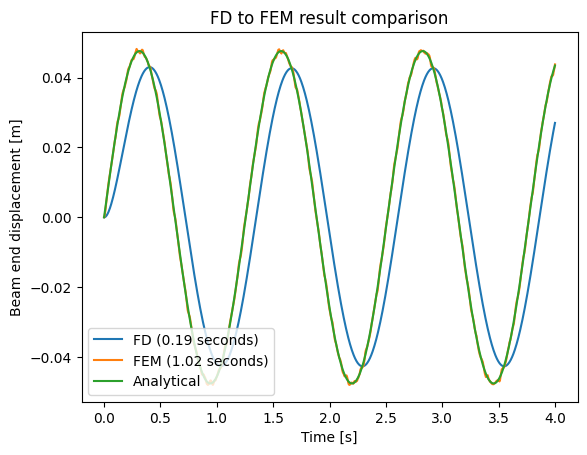

In [145]:
t_FD = sol_FD.t
y_FD = sol_FD.y[int(len(sol_FD.y)/2)-1]
plt.plot(t_FD, y_FD, label=f"FD ({FD_EndTime-FD_StartTime:.2f} seconds)")

t_FEM = sol_FEM.t
y_FEM = sol_FEM.y[int(len(sol_FEM.y)/2)-1]
plt.plot(t_FEM, y_FEM, label=f"FEM ({FEM_EndTime-FEM_StartTime:.2f} seconds)")

# Simplified analytical -- assumption of static behaviour due to slow frequency
y_ana = P(t_FD)/E/A*L
plt.plot(t_FD, y_ana, label="Analytical")

plt.title("FD to FEM result comparison")
plt.legend(loc=3)
plt.xlabel("Time [s]")
plt.ylabel("Beam end displacement [m]");
